In [9]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import lsqfit

In [10]:
from b2heavy.FnalHISQMetadata import params as mData

In [11]:
from b2heavy.TwoPointFunctions.utils     import correlation_diagnostics
from b2heavy.TwoPointFunctions.types2pts import CorrelatorIO, plot_effective_coeffs
from b2heavy.TwoPointFunctions.fitter    import StagFitter

In [12]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

Select a case for which we want to calculate the recoil parameter

In [13]:
ENSEMBLE = 'Coarse-1'
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'

BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}


In [14]:
mdata = mData(ENSEMBLE)
LVOL   = mdata['L']
alphas = mdata['alphaS'] 

# 3-pts functions

In [32]:
ENSEMBLE = 'Coarse-1'
TMIN     = 3
NSTATES  = 1
readfrom = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/presentation'

Condition number of the correlation matrix is 1.18e+02
Advised svd cut parameter for is 0.008443124579555325
# ---------- 1+1 fit in (3, 9) for ratio: XFSTPAR of ens: Coarse-1 for mom: 100 --------------
Least Square Fit:
  chi2/dof [dof] = 0.64 [14]    Q = 0.83    logGBF = 51.13

Parameters:
        ratio 0   -0.101 (49)     [ -0.07 (10) ]  
       dE_src 0    -1.63 (93)     [ -1.7 (1.6) ]  
         A_1S 0    -0.58 (18)     [    0 ± 1.0 ]  
         B_1S 0    -0.45 (29)     [    0 ± 1.0 ]  
         A_RW 0    -0.37 (30)     [    0 ± 1.0 ]  
         B_RW 0    -0.33 (37)     [    0 ± 1.0 ]  

Settings:
  svdcut/n = 0/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 31/0.0)
  fitter = scipy_least_squares    method = trf

# red chi2     = 9.03
# chi2_exp     = 12.31
# chi2/chi_exp = 0.73
# p-value      = 0.74
Condition number of the correlation matrix is 1.17e+02
Advised svd cut parameter for is 0.00854795737567974
# ---------- 1+1 fit in (3, 9) for ratio: XFSTPAR of ens: Coarse-1 for mo

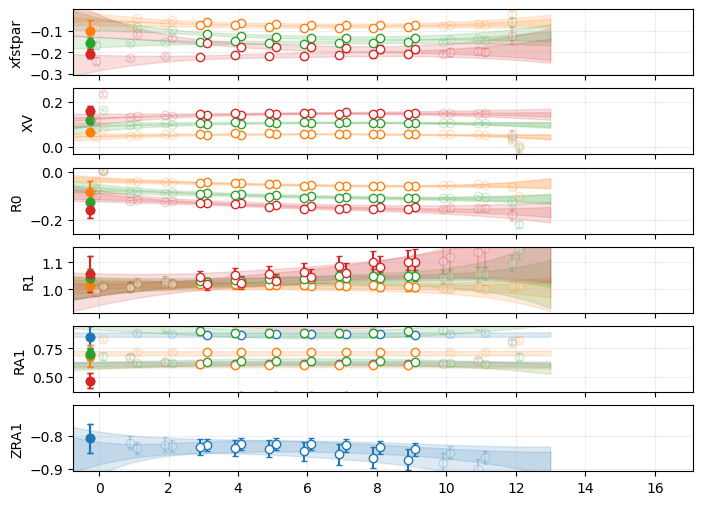

In [34]:
ratios = ['xfstpar','XV','R0','R1','RA1','ZRA1']
# ratios = ['xfstpar','RA1']

fig, ax = plt.subplots(len(ratios),1,sharex=True, figsize=(8,6))


R = {}
for ir,ratio in enumerate(ratios):
    ratioval = []
    # for i,mom in enumerate(['000','100','200','300','400']):
    for i,mom in enumerate(['000','100','200','300']):
        if mom=='000' and 'RA1' not in ratio:
            continue
        elif mom!='000' and ratio=='ZRA1':
            continue

        requisites = ratio_prerequisites(
            ENSEMBLE, ratio, mom, readfrom=readfrom, jk=False
        )

        io = RatioIO(ENSEMBLE,ratio,mom,PathToDataDir='/Users/pietro/code/data_analysis/BtoD/Alex/')
        robj = RatioFitter(
            io,
            jkBin     = BINSIZE[ENSEMBLE],
            smearing  = ['1S','RW'],
            readfrom  = readfrom,
            **requisites
        )

        trange = (TMIN,robj.Tb-TMIN-1)

        # Calculate svd cut
        x,ydata,ysample = robj.format(trange=trange,alljk=True)
        svd = correlation_diagnostics(ysample['1S'])

        cov_specs = dict(scale=True, shrink=True, svd=svd)

        # Compute fit priors
        fit,p = read_config_fit(
            tag  = f'fit2pt_config_{ENSEMBLE}_Dst_{mom}',
            path = readfrom
        )
        K  = gv.gvar(ydata['1S'][robj.Ta//2].mean,0.1)
        dE = [
            gv.gvar(p['E'][2*n+2].mean,p['E'][2*n+2].sdev*3)
            for n in range(NSTATES)
        ]

        pr = robj.priors(NSTATES,K=K,dE_src=dE)

        fit = robj.fit(
            Nstates = NSTATES,
            trange  = trange,
            verbose = False,
            priors  = pr,
            **cov_specs
        )
        ratioval.append(fit.pmean['ratio'][0])
        R[ratio,mom] = fit.p['ratio'][0]
        res = robj.fit_result(Nexc=NSTATES, trange=trange, priors=pr)

        if ratio=='xfstpar':
            dump_fit_object(f'{readfrom}/fit3pt_config_{ENSEMBLE}_xfstpar_{mom}',fit,**res)

        robj.plot_fit(ax[ir],NSTATES,trange,color=f'C{i}',label=mom)


    ax[ir].set_ylabel(ratio)
    ax[ir].set_xlim(xmin=-0.75,xmax=17.1)
    ax[ir].set_ylim(ymin=min(ratioval)-0.1,ymax=max(ratioval)+0.1)

    ax[ir].grid(alpha=0.2)


In [36]:
# rs = {r: np.asarray([R[r,mom] for mom in ['100','200','300','400']]) for r in ['xfstpar','XV','R0','R1','RA1']}
rs = {r: np.asarray([R[r,mom] for mom in ['100','200','300']]) for r in ['xfstpar','XV','R0','R1','RA1']}

rho_Aj = gv.gvar('1.0(0)')
rho_A4 = gv.gvar('1.0(0)')
rho_Vj = gv.gvar('1.0(0)')

w   = (1+rs['xfstpar']**2)/(1-rs['xfstpar']**2)
hA1 = rho_Aj * 2*rs['RA1']/(w + 1)
hA2 = rho_Aj * 2*rs['RA1']/(w**2 -1) * (w*rs['R1'] - np.sqrt(w**2 -1) * rho_A4/rho_Aj * rs['R0'] -1)
hA3 = rho_Aj * 2*rs['RA1']/(w**2 -1) * (w - rs['R1'])
hV  = 2*rs['RA1']/np.sqrt(w**2 -1) * rs['XV']

# $h_{A_1}$

<ErrorbarContainer object of 3 artists>

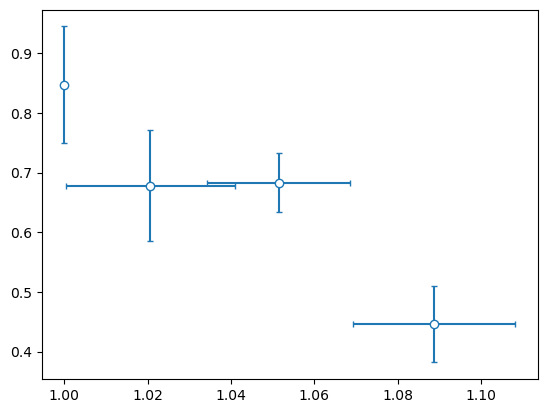

In [37]:
w   = (1+rs['xfstpar']**2)/(1-rs['xfstpar']**2)
hA1 = rho_Aj * 2*rs['RA1']/(w + 1)

hA1 = np.insert(hA1,0,R['RA1','000'])
w   = np.insert(w,0,gv.gvar('1(0)'))

x,xerr = gv.mean(w),gv.sdev(w)
plt.errorbar(x, gv.mean(hA1), yerr=gv.sdev(hA1), xerr=xerr,fmt='o', ecolor='C0', mfc='w', color='C0', capsize=2.)

# Alltogether

<ErrorbarContainer object of 3 artists>

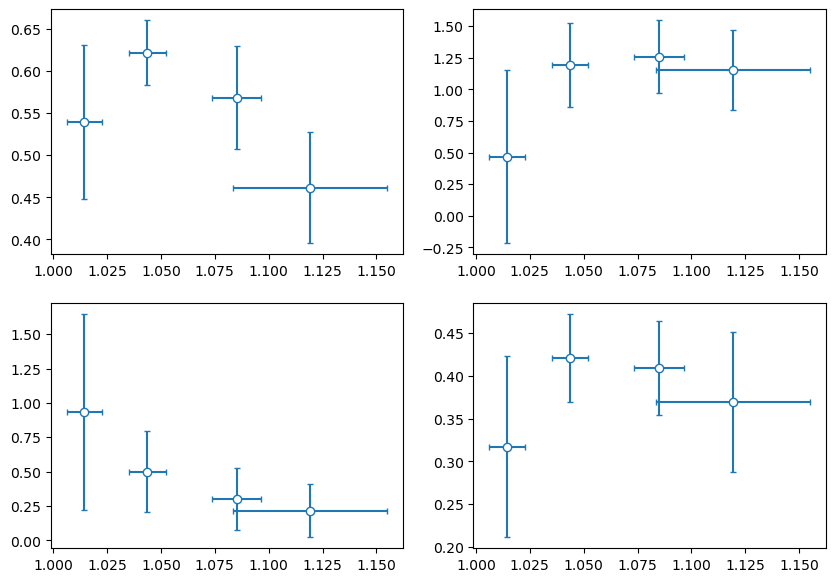

In [19]:
fig,ax = plt.subplots(2,2, figsize=(10,7))

x,xerr = gv.mean(w),gv.sdev(w)

ax[0,0].errorbar(x, gv.mean(hA1), yerr=gv.sdev(hA1), xerr=xerr,fmt='o', ecolor='C0', mfc='w', color='C0', capsize=2.)
ax[0,1].errorbar(x, gv.mean(hA2), yerr=gv.sdev(hA2), xerr=xerr,fmt='o', ecolor='C0', mfc='w', color='C0', capsize=2.)
ax[1,0].errorbar(x, gv.mean(hA3), yerr=gv.sdev(hA3), xerr=xerr,fmt='o', ecolor='C0', mfc='w', color='C0', capsize=2.)
ax[1,1].errorbar(x, gv.mean(hV ), yerr=gv.sdev(hV ), xerr=xerr,fmt='o', ecolor='C0', mfc='w', color='C0', capsize=2.)